# Contents
<a name="Contents"></a>  
* <a href="#Temperature based">Temperature based</a>  
    * <a href="#eq1">Eq.1</a>  
    * <a href="#eq2">Eq.2</a>  
    * <a href="#eq3">Eq.3</a>  
    * <a href="#eq4">Eq.4</a>  
    * <a href="#eq5">Eq.5</a>  
    * <a href="#eq6">Eq.6</a>  
    * <a href="#eq7">Eq.7</a>  
* <a href="#Radiation Based">Radiation Based</a>  
    * <a href="#eq8">Eq.8</a>  
    * <a href="#eq9">Eq.9</a>  
    * <a href="#eq10">Eq.10</a>  
    * <a href="#eq11">Eq.11</a>  
    * <a href="#eq12">Eq.12</a>  
    * <a href="#eq13">Eq.13</a>  
    * <a href="#eq14">Eq.14</a>  
    * <a href="#eq15">Eq.15</a>  
* <a href="#Mass Transfer based">Mass Transfer based</a>  
    * <a href="#eq16">Eq.16</a>  
    * <a href="#eq17">Eq.17</a>  
    * <a href="#eq18">Eq.18</a>  
    * <a href="#eq19">Eq.19</a>  
    * <a href="#eq20">Eq.20</a>  
* <a href="#Combination methods">Combination methods</a>  
    * <a href="#eq21">Eq.21</a>  
    * <a href="#eq22">Eq.22</a>  
    * <a href="#eq23">Eq.23</a>  
* <a href="#Radiation methods">Radiation methods</a>  
    * <a href="#eq2.1">Eq.2.1</a>  
    * <a href="#eq2.2">Eq.2.2</a>  
    * <a href="#eq2.3">Eq.2.3</a>  
    * <a href="#eq2.4">Eq.2.4</a>  
    * <a href="#eq2.5">Eq.2.5</a>  
    * <a href="#eq2.6">Eq.2.6</a>  
    * <a href="#eq2.7">Eq.2.7</a>

## READ DATA

In [1]:
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math

z = 30
gamma = 0.0674
λ = 2256/1000
φ = 40.52

# data file
df = pd.read_excel('auth.xlsx', skiprows=[1, 2], index_col = 0)
X_multi = df.drop('Ετο', 1)
Y_target = df.Ετο

## Plot intervals

In [2]:
def plot_int(x, par, quantile1, quantile2):
    if not x.var() < 10**-8:
        fig, ax = plt.subplots(ncols=1, figsize=(8, 4))
        sns.kdeplot(x, color = 'b', zorder = 11)
        sns.histplot(x, color = 'cornflowerblue', ax=ax, stat = 'density', kde = True, zorder = 8)
        max_hist = np.array([h.get_height() for h in sns.kdeplot(x).patches]).max()
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        left, middle, right = np.percentile(x, [quantile1, 50, quantile2])
        ax.set_title('The median value of the parameter {} is {}'.format(par, np.round(np.median(x), 4)))
        ax.vlines(np.median(x), 0, np.interp(np.median(x), xs, ys), color = 'black', linestyle = '--', zorder = 9)
        sns.histplot(x, stat='density', color = 'cornflowerblue')
        ax.fill_between(xs, 0, ys, where=(xs >= right), interpolate=True, facecolor='silver', zorder = 10)
        ax.fill_between(xs, 0, ys, where=(xs <= left), interpolate=True, facecolor='silver', zorder = 10)
        ax.fill_between(xs, ys, max_hist, where=(xs < left), interpolate=True, facecolor='white', zorder = 10)
        ax.fill_between(xs, ys, max_hist, where=(xs > right), interpolate=True, facecolor='white', zorder = 10)
        ax.set_ylim(ymin=0)
        plt.grid(False)
        plt.legend([])
        plt.show()
    else:
        print('Variance is close to zero; plot of {} is not produced'.format(par))

def metrics(O, P):
    mae = sklearn.metrics.mean_absolute_error(O, P)
    mdae = sklearn.metrics.median_absolute_error(O, P)
    RSq = sklearn.metrics.r2_score(O, P)
    rmse = sklearn.metrics.mean_squared_error(O, P, squared=False)
    R2 = stats.linregress(O, P)[2]**2
    return mae, mdae, rmse, RSq, R2

def plot_regression(O, P, evalu_valid_m):
    plt.figure(figsize = (6, 6))
#     plt.title('R2 calibration is {:.4f}, R2 validation is {:.4f} and \n whole R2 is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2'], evaluation[-1]))
    plt.grid(zorder = 1)
    plt.scatter(O, P, edgecolor='black', linewidth=1, zorder = 2)
    regmodel = LinearRegression()
    regmodel.fit(O.reshape(-1,1), P)
    plt.plot(O.reshape(-1,1), regmodel.predict(O.reshape(-1,1)), color = 'orange', linestyle = '--', zorder = 3)
    plt.xlim([0, np.max([O, P]) + 1])
    plt.ylim([0, np.max([O, P]) + 1])
    plt.plot([0, np.max([O, P]) + 1], [0, np.max([O, P]) + 1], 'r--', zorder = 4)
    plt.legend(['Regression R2: {:.3f}'.format(evalu_valid_m), '1:1 Plot', 'Observed - Predicted'])
    plt.xlabel('Observed ETo [m]')
    plt.ylabel('Predicted ETo [m]');

In [3]:
a = [item for item in range(1, 24)]
indecies = ["Eq." + str(item) for item in a]

equations = pd.DataFrame(index = indecies, columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'r2_whole'])

<a name="Temperature based"></a>
## Temperature Based

<a name="eq1">Answer to eq. 1</a>  
<a href="#Contents">Back to equations</a>
### Eq. 1

Variance is close to zero; plot of a is not produced


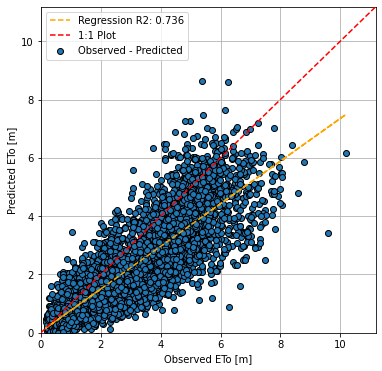

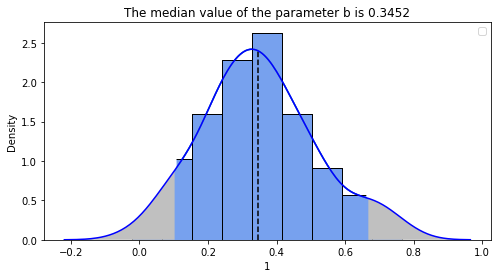

In [4]:
bootstrap = 100
p1 = 1
params = []
evalu_validation = []
evalu = []

# data file
df = pd.read_excel('auth.xlsx', skiprows=[1, 2], index_col = 0)
X_multi = df.drop('Ετο', 1)
Y_target = df.Ετο

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    xm2 = np.array(X_train["RH"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        y = (a * (b + xm1) ** p1) * (100 - xm2)
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(2) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] * (x[1] + X_test["T"]) ** p1) * (100 - X_test["RH"])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] * (params_m[1] + df["T"]) ** p1) * (100 - df["RH"])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

equations.loc['Eq.1'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.1'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp1 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r1 = metrics(Y_target, et)[-1]
equations.loc['Eq.1'][-1] = r1

<a name="eq2">Answer to eq. 2</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2

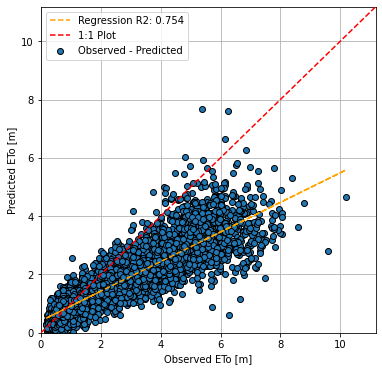

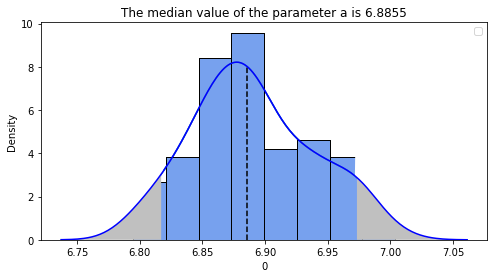

In [5]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    xm2 = np.array(X_train["RH"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        y = a * (xm1/xm2)               # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(1) #Number of parameters
    x0[0] = 0.0 # a
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["T"] / X_test["RH"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["T"] / df["RH"]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)

equations.loc['Eq.2'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.2'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp2 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r2 = metrics(Y_target, et)[-1]
equations.loc['Eq.2'][-1] = r2

<a name="eq3">Answer to eq. 3</a>  
<a href="#Contents">Back to equations</a>
### Eq. 3

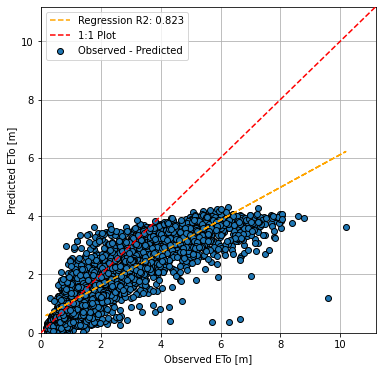

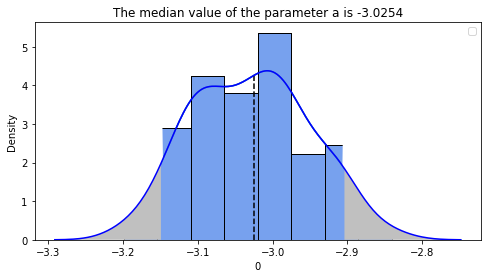

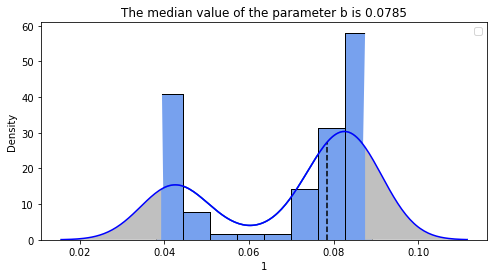

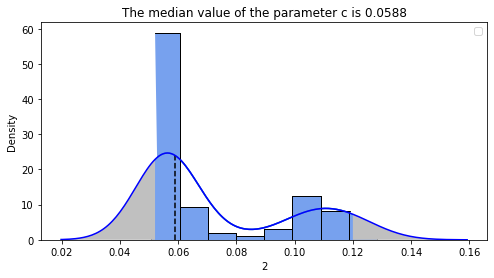

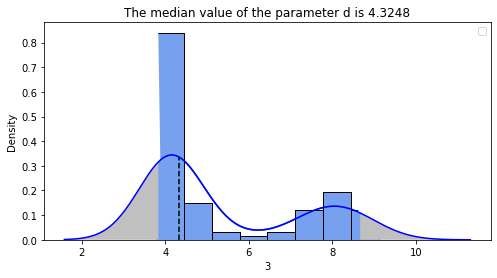

In [6]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["N"])
    xm2 = np.array(X_train["T"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]

        y = a + b * xm1 * (c * xm2 + d)                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(4) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    x0[3] = 0.1 # d
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] + X_test["N"] * x[1] * (x[2] * X_test["T"] + x[3])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] + df["N"] * params_m[1] * (params_m[2] * df["T"] + params_m[3])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)

equations.loc['Eq.3'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.3'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp3 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r3 = metrics(Y_target, et)[-1]
equations.loc['Eq.3'][-1] = r3

<a name="eq4">Answer to eq. 4</a>  
<a href="#Contents">Back to equations</a>
### Eq. 4

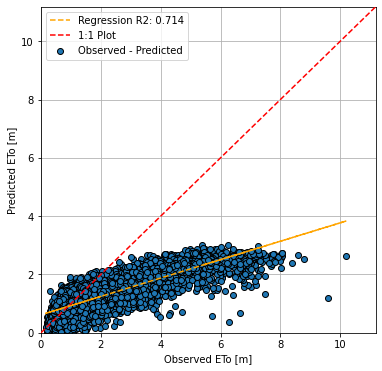

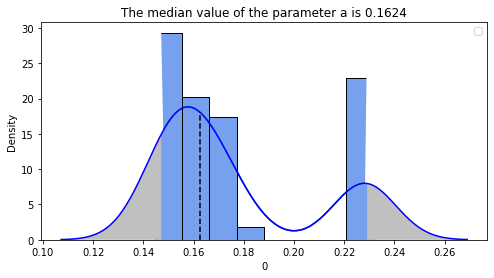

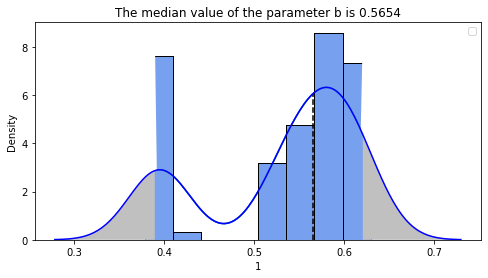

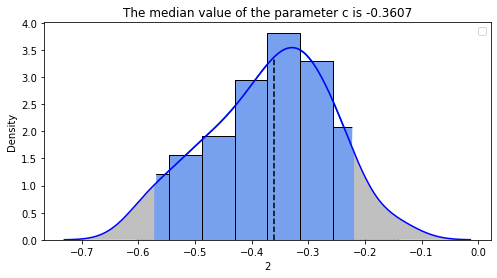

In [7]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []
for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * (b * xm1 + c)                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (x[1] * X_test["T"] + x[2])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * (params_m[1] * df["T"] + params_m[2])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.4'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.4'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp4 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r4 = metrics(Y_target, et)[-1]
equations.loc['Eq.4'][-1] = r4

<a name="eq5">Answer to eq. 5</a>  
<a href="#Contents">Back to equations</a>
### Eq. 5

Variance is close to zero; plot of a is not produced


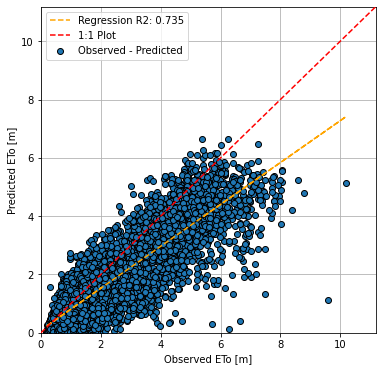

In [8]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []
p1 = 2

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        y = a * xm1 ** p1                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 1 # a
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["T"] ** p1

    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["T"] ** p1
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)

equations.loc['Eq.5'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.5'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp5 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r5 = metrics(Y_target, et)[-1]
equations.loc['Eq.5'][-1] = r5

<a name="eq6">Answer to eq. 6</a>  
<a href="#Contents">Back to equations</a>
### Eq. 6

C:\Users\owner\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


Variance is close to zero; plot of a is not produced


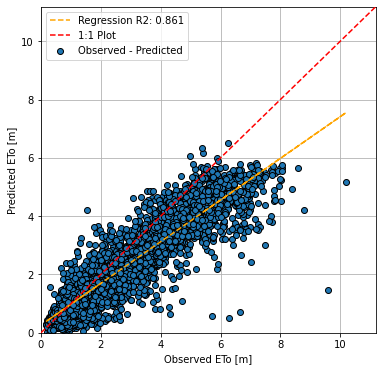

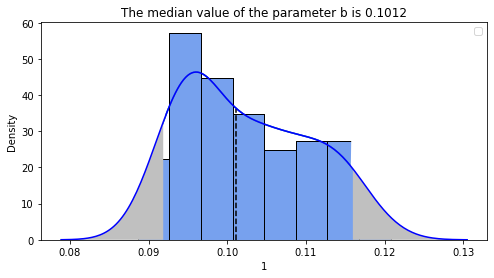

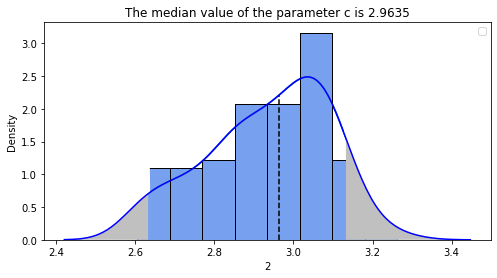

In [9]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Ra"])
    xm2 = np.array(X_train["dt"])
    xm3 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * xm1 * (xm2 ** b) * (xm3 + c)                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["Ra"] *(X_test["dt"] ** x[1]) * (X_test["T"] + x[2])

    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["Ra"] *(df["dt"] ** params_m[1]) * (df["T"] + params_m[2])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.6'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.6'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp6 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r6 = metrics(Y_target, et)[-1]
equations.loc['Eq.6'][-1] = r6

<a name="eq7">Answer to eq. 7</a>  
<a href="#Contents">Back to equations</a>
### Eq. 7

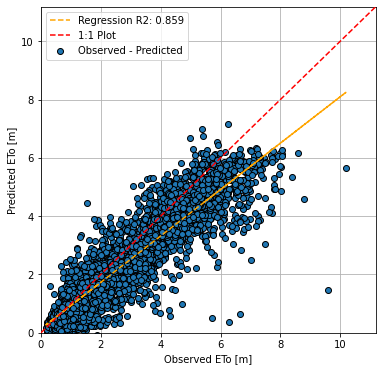

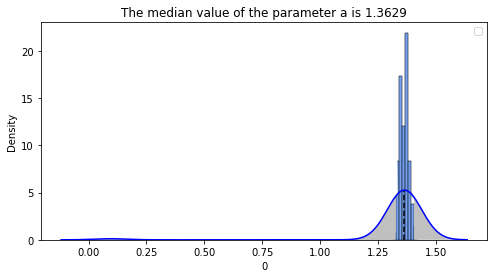

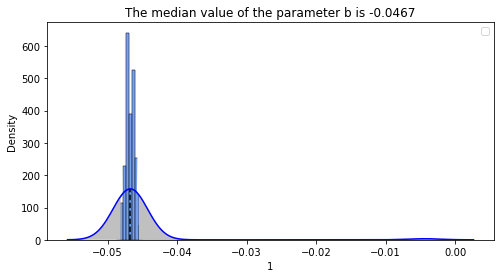

Variance is close to zero; plot of c is not produced


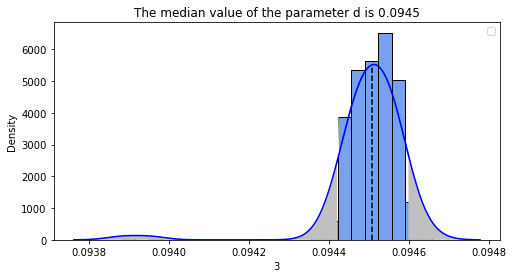

In [10]:
bootstrap = 100
p1 = 0.1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Ra"])
    xm2 = np.array(X_train["dt"])
    xm3 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]

        y = (a + b * z) * c * xm1 * xm2 ** p1 * (xm3 + d)                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(4) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    x0[3] = 0.1 # d
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] + x[1] * z) * x[2] * X_test["Ra"] * X_test["dt"] ** p1 * (X_test["T"] + x[3])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] + params_m[1] * z) * params_m[2] * df["Ra"] * df["dt"] ** p1 * (df["T"] + params_m[3])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)

equations.loc['Eq.7'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.7'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp7 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r7 = metrics(Y_target, et)[-1]
equations.loc['Eq.7'][-1] = r7

<a name="Radiation Based"></a>
## Radiation Based

<a name="eq8">Answer to eq. 8</a>  
<a href="#Contents">Back to equations</a>
### Eq. 8

In [ ]:
bootstrap = 100

params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Delta"])
    xm2 = np.array(X_train["RS"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        y =  a * (xm1/(xm1 + gamma)) * xm2 + b                # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(2) #Number of parameters
    x0[0] = 0.0 # a
    x0[1] = 0.0 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (X_test["Delta"]/(X_test["Delta"] + gamma)) * X_test["RS"] + x[1]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * (df["Delta"]/(df["Delta"] + gamma)) * df["RS"] + params_m[1]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

equations.loc['Eq.8'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.8'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp8 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r8 = metrics(Y_target, et)[-1]
equations.loc['Eq.8'][-1] = r8

C:\Users\owner\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


<a name="eq9">Answer to eq. 9</a>  
<a href="#Contents">Back to equations</a>
### Eq. 9

In [ ]:
bootstrap = 100

params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    xm2 = np.array(X_train["RS"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y =  a * (xm1/(xm1 + b)) * (xm2 + c)                # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (X_test["T"]/(X_test["T"] + x[1])) * (X_test["RS"] + x[2])

    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * (df["T"]/(df["T"] + params_m[1])) * (df["RS"] + params_m[2])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.9'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.9'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp9 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r9 = metrics(Y_target, et)[-1]
equations.loc['Eq.9'][-1] = r9

<a name="eq10">Answer to eq. 10</a>  
<a href="#Contents">Back to equations</a>
### Eq. 10

In [ ]:
bootstrap = 100

params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Delta"])
    xm2 = np.array(X_train["Rn"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]

        y =  a * (xm1/(xm1 + gamma)) * xm2            # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(1) #Number of parameters
    x0[0] = 1 # a
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (X_test["Delta"]/(X_test["Delta"] + gamma)) * X_test["Rn"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * (df["Delta"]/(df["Delta"] + gamma)) * df["Rn"]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)

equations.loc['Eq.10'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.10'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp10 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r10 = metrics(Y_target, et)[-1]
equations.loc['Eq.10'][-1] = r10

<a name="eq11">Answer to eq. 11</a>  
<a href="#Contents">Back to equations</a>
### Eq. 11

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]

        y = (a * xm2 + b) * xm1 * c / λ                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] * X_test["T"] + x[1]) * X_test["RS"] * x[2]

    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] * df["T"] + params_m[1]) * df["RS"] * params_m[2]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.11'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.11'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp11 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r11 = metrics(Y_target, et)[-1]
equations.loc['Eq.11'][-1] = r11

<a name="eq12">Answer to eq. 12</a>  
<a href="#Contents">Back to equations</a>
### Eq.12

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Rn"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        y = a * xm1 / λ              # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(1) #Number of parameters
    x0[0] = 0.1 # a
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["Rn"] / λ
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["Rn"] / λ
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)

equations.loc['Eq.12'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.12'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp12 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r12 = metrics(Y_target, et)[-1]
equations.loc['Eq.12'][-1] = r12

<a name="eq13">Answer to eq. 13</a>  
<a href="#Contents">Back to equations</a>
### Eq. 13

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * xm1 + b * xm2 + c                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["RS"] + x[1] * X_test["T"] + x[2]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["RS"] + params_m[1] * df["T"] + params_m[2]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.13'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.13'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp13 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r13 = metrics(Y_target, et)[-1]
equations.loc['Eq.13'][-1] = r13

<a name="eq14">Answer to eq. 14</a>  
<a href="#Contents">Back to equations</a>
### Eq. 14

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Rn"])
    xm2 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * xm1 + b * xm2 + c                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c

    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["RS"] + x[1] * X_test["T"] + x[2]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["RS"] + params_m[1] * df["T"] + params_m[2]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.14'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.14'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp14 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r14 = metrics(Y_target, et)[-1]
equations.loc['Eq.14'][-1] = r14

<a name="eq15">Answer to eq. 15</a>  
<a href="#Contents">Back to equations</a>
### Eq. 15

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["Tmax"])
    xm3 = np.array(X_train["Tmin"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]

        y = a * xm1 * (b * xm2 + c * xm3 + d)
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(4) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    x0[3] = 0.1 # d
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["RS"] * (x[1] * X_test["Tmax"] + x[2] * X_test["Tmin"] + x[3])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["RS"] * (params_m[1] * df["Tmax"] + params_m[2] * df["Tmin"] + params_m[3])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)

equations.loc['Eq.15'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.15'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp15 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r15 = metrics(Y_target, et)[-1]
equations.loc['Eq.15'][-1] = r15

<a name="Mass Transfer based"></a>
## Mass Transfer based

<a name="eq16">Answer to eq. 16</a>  
<a href="#Contents">Back to equations</a>
### Eq. 16

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["U"])
    xm2 = np.array(X_train["es-ea"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        y = (a + b * xm1) * xm2                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] + x[1] * X_test["U"]) * X_test["es-ea"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] + params_m[1] * df["U"]) * df["es-ea"]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

equations.loc['Eq.16'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.16'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp16 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r16 = metrics(Y_target, et)[-1]
equations.loc['Eq.16'][-1] = r16

<a name="eq17">Answer to eq. 17</a>  
<a href="#Contents">Back to equations</a>
### Eq. 17

In [ ]:
bootstrap = 100
p1 = 1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["U"])
    xm2 = np.array(X_train["es-ea"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]

        y = (a + (b * xm1) ** p1) * xm2                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] + (x[1] * X_test["U"]) ** p1) * X_test["es-ea"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] + (params_m[1] * df["U"]) ** p1) * df["es-ea"]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

equations.loc['Eq.17'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.17'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp17 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r17 = metrics(Y_target, et)[-1]
equations.loc['Eq.17'][-1] = r17

<a name="eq18">Answer to eq. 18</a>  
<a href="#Contents">Back to equations</a>
### Eq. 18

In [ ]:
bootstrap = 100
p1 = 0.1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["U"])
    xm2 = np.array(X_train["es-ea"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]

        y = a * xm1 ** p1 * xm2             # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(1) #Number of parameters
    x0[0] = 1 # a
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] * X_test["U"] ** p1) * X_test["es-ea"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = (params_m[0] * df["U"] ** p1) * df["es-ea"]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)

equations.loc['Eq.18'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.18'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp18 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r18 = metrics(Y_target, et)[-1]
equations.loc['Eq.18'][-1] = r18

<a name="eq19">Answer to eq. 19</a>  
<a href="#Contents">Back to equations</a>
### Eq. 19

In [ ]:
bootstrap = 100
p1 = 1
p2 = 1
params = []
evalu_validation = []
evalu = []
for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    xm2 = np.array(X_train["RH"])
    xm3 = np.array(X_train["U"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]
        e = x[4]
        y = a * ((xm1 + b) ** p1) * ((c + xm2) ** p2) * (d * xm3 + e)
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(5) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    x0[2] = 1 # c
    x0[3] = 1 # d
    x0[4] = 1 # e
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * ((X_test["T"] + x[1]) ** p1) * ((x[2] + X_test["RH"]) ** p2) * (x[3] * X_test["U"] + x[4])
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * ((df["T"] + params_m[1]) ** p1) * ((params_m[2] + df["RH"]) ** p2) * (params_m[3] * df["U"] + params_m[4])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 4], 'e', 5, 95)

equations.loc['Eq.19'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.19'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp19 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r19 = metrics(Y_target, et)[-1]
equations.loc['Eq.19'][-1] = r19

<a name="eq20">Answer to eq. 20</a>  
<a href="#Contents">Back to equations</a>
### Eq. 20

In [ ]:
bootstrap = 100
p1 = 0.7
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Ra"])
    xm2 = np.array(X_train["es-ea"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * np.sin(xm1 /360 * 2 * np.pi) ** 3 + b * xm2 ** p1 + c             # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3)
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c

    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)
    
    #Validation
    y_pred = x[0] * np.sin(X_test["Ra"] / 360 * 2 * np.pi) ** 3 + x[1] * X_test["es-ea"] ** p1 + x[2]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * np.sin(df["Ra"] / 360 * 2 * np.pi) ** 3 + params_m[1] * df["es-ea"] ** p1 + params_m[2]
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

equations.loc['Eq.20'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.20'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp20 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r20 = metrics(Y_target, et)[-1]
equations.loc['Eq.20'][-1] = r20

<a name="Combination methods"></a>
## Combination methods

<a name="eq21">Answer to eq. 21</a>  
<a href="#Contents">Back to equations</a>
### Eq. 21

In [ ]:
bootstrap = 100
p1 = 1
p2 = 1
p3 = 0.3
p4 = 1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["T"])
    xm3 = np.array(X_train["Tmin"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]
        e = x[4]
        f = x[5]
        g = x[6]
        y = a * xm1 * (xm2 + b) ** p1 - c * xm1 ** p2 * φ ** p3 + d * (xm2 + e) * (f * xm2 - xm3 - g)**p4
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(11) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    x0[2] = 1 # c
    x0[3] = 1 # d
    x0[4] = 1 # e
    x0[5] = 1 # f
    x0[6] = 1 # g
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["RS"] * (X_test["T"] + x[1]) ** p1 - x[2] * X_test["RS"] ** p2 * φ ** p3 + x[3] * (X_test["T"] + x[4]) * (x[5] * X_test["T"] - X_test["Tmin"] - x[6]) ** p4
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * df["RS"] * (df["T"] + params_m[1]) ** p1 - params_m[2] * df["RS"] ** p2 * φ ** p3 + params_m[3] * (df["T"] + params_m[4]) * (params_m[5] * df["T"] - df["Tmin"] - params_m[6]) ** p4
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 4], 'e', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 5], 'f', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 6], 'g', 5, 95)

equations.loc['Eq.21'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.21'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp21 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r21 = metrics(Y_target, et)[-1]
equations.loc['Eq.21'][-1] = r21

<a name="eq22">Answer to eq. 22</a>  
<a href="#Contents">Back to equations</a>
### Eq. 22

In [ ]:
bootstrap = 100
p1 = 1
p2 = 1
p3 = 1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["T"])
    xm3 = np.array(X_train["Tmin"])
    xm4 = np.array(X_train["RH"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]
        e = x[4]
        y = a * xm1 * ((xm2 + b) ** p1) + c * (xm1 ** p2) * (φ ** p3) + d * (xm2 + e) * (1 - xm4/100)
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(11) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    x0[2] = 1 # c
    x0[3] = 1 # d
    x0[4] = 1 # e
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (X_test["RS"] * (X_test["T"] + x[1]) ** p1) + x[2] * (X_test["RS"] ** p2) * (φ ** p3) + x[3] * (X_test["T"] + x[4]) * (1 - X_test["RH"]/100)
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] * (df["RS"] * (df["T"] + params_m[1]) ** p1) + params_m[2] * (df["RS"] ** p2) * (φ ** p3) + params_m[3] * (df["T"] + params_m[4]) * (1 - df["RH"]/100)
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 4], 'e', 5, 95)

equations.loc['Eq.22'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.22'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp22 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r22 = metrics(Y_target, et)[-1]
equations.loc['Eq.22'][-1] = r22

<a name="eq23">Answer to eq. 23</a>  
<a href="#Contents">Back to equations</a>
### Eq. 23

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RH"])
    xm2 = np.array(X_train["RS"])
    xm3 = np.array(X_train["T"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]
        e = [4]
        f = [5]
        g = [6]
        h = [7]
        i = [8]
        j = [9]
        k = [10]
        l = [11]
#         c1 = e + f * xm1 + g * xm2 + h * xm1 * xm2
#         c2 = i + j * xm3 + k * xm2 + l * xm2 * xm3
        y = a + b * (i + j * xm3 + k * xm2 + l * xm2 * xm3) + c * (e + f * xm1 + g * xm2 + h * xm1 * xm2) + d * (e + f * xm1 + g * xm2 + h * xm1 * xm2) * (i + j * xm3 + k * xm2 + l * xm2 * xm3)
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(12) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    x0[2] = 1 # c
    x0[3] = 1 # d
    x0[4] = 1 # e
    x0[5] = 1 # f
    x0[6] = 1 # g
    x0[7] = 1 # h
    x0[8] = 10 # i
    x0[9] = 10 # j
    x0[10] = 10 # k
    x0[11] = 10 # l
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
#     c1_pred = x[4] + x[5] * X_test["RH"] + x[6] * X_test["RS"] + x[7] * X_test["RH"] * X_test["RS"]
#     c2_pred = x[8] + x[9] * X_test["T"] + x[10] * X_test["RS"] + x[11] * X_test["RS"] * X_test["T"]
    y_pred = x[0] + x[1] * (x[8] + x[9] * X_test["T"] + x[10] * X_test["RS"] + x[11] * X_test["RS"] * X_test["T"]) + x[2] * (x[4] + x[5] * X_test["RH"] + x[6] * X_test["RS"] + x[7] * X_test["RH"] * X_test["RS"]) + x[3] * (x[4] + x[5] * X_test["RH"] + x[6] * X_test["RS"] + x[7] * X_test["RH"] * X_test["RS"]) * (x[8] + x[9] * X_test["T"] + x[10] * X_test["RS"] + x[11] * X_test["RS"] * X_test["T"])    
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

et = params_m[0] + params_m[1] * (params_m[8] + params_m[9] * df["T"] + params_m[10] * df["RS"] + params_m[11] * df["RS"] * df["T"]) + params_m[2] * (params_m[4] + params_m[5] * df["RH"] + params_m[6] * df["RS"] + params_m[7] * df["RH"] * df["RS"]) + params_m[3] * (params_m[4] + params_m[5] * df["RH"] + params_m[6] * df["RS"] + params_m[7] * df["RH"] * df["RS"]) * (params_m[8] + params_m[9] * df["T"] + params_m[10] * df["RS"] + params_m[11] * df["RS"] * df["T"])
plot_regression(np.array(Y_target), np.array(et), evalu_valid_m[4])

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 4], 'e', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 5], 'f', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 6], 'g', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 7], 'h', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 8], 'i', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 9], 'j', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 10], 'k', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 11], 'l', 5, 95)

equations.loc['Eq.23'][:len(evalu_valid_m)] = evalu_valid_m
equations.loc['Eq.23'][len(evalu_valid_m):(len(evalu_valid_m) + len(params_m))] = params_m

exp23 = pd.merge((pd.merge(evalu, evalu_validation, left_index=True, right_index=True)), pd.DataFrame(params), left_index=True, right_index=True)
r23 = metrics(Y_target, et)[-1]
equations.loc['Eq.23'][-1] = r23

In [ ]:
equations.astype(float).round(3)
equations.astype(float).round(3).to_excel('evaluation.xlsx')

In [ ]:
exp = [exp1, exp2, exp3, exp4, exp5, exp6, exp7, exp8, exp9, exp10, exp11, exp12, exp13, exp14, exp15, exp16, exp17, exp18, exp19, exp20, exp21, exp22, exp23]
    
with pd.ExcelWriter('bootstrap.xlsx') as writer:
    for i in range(0, 23):
        exp[i].to_excel(writer, sheet_name='Eq.{}'.format(i + 1))

<a name="Radiation methods"></a>
## Radiation methods

<a name="eq2.1">Answer to eq. 2.1</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.1

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["dt"])
    xm2 = np.array(X_train["Ra"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]

        y = a * xm1 ** b * xm2                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(2) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["dt"] ** x[1] * X_test["Ra"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

<a name="eq2.2">Answer to eq. 2.2</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.2

In [ ]:
bootstrap = 100
p1 = 1
p2 = 1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["dt"])
    xm2 = np.array(X_train["Ra"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a * (((b - c * z)/z) ** p1) * (xm1 ** p2) * xm2                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 1 # a
    x0[1] = 1 # b
    x0[2] = 1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * (((x[1] - x[2] * z)/z) ** p1) * (X_test["dt"] ** p2) * X_test["Ra"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

<a name="eq2.3">Answer to eq. 2.3</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.3

In [ ]:
bootstrap = 100
p1 = 1
p2 = 1
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["dt"])
    xm2 = np.array(X_train["Ra"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = (a * (xm1 ** p1) + b * xm1 + c) * (xm1 ** p2) * xm2               # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] * (X_test["dt"] ** p1) + x[1] * X_test["dt"] + x[2]) * (X_test["dt"] ** p2) * X_test["Ra"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

<a name="eq2.4">Answer to eq. 2.4</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.4

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["dt"])
    xm2 = np.array(X_train["Ra"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        y = (a * np.log(xm1) + b) * xm2                # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(2) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] * np.log(X_test["dt"]) + x[1]) * X_test["Ra"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');
                                                          
plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)

<a name="eq2.5">Answer to eq. 2.5</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.5

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []
for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["T"])
    xm2 = np.array(X_train["RH"])
    xm3 = np.array(X_train["Ra"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = (a + b * xm1 + c * xm2) * xm3                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = (x[0] + x[1] * X_test["T"] + x[2] * X_test["RH"]) * X_test["Ra"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

<a name="eq2.6">Answer to eq. 2.6</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.6

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []
for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["Ra"])
    xm2 = np.array(X_train["T"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        y = a + b * xm1 + c * xm2                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    
    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] + x[1] * X_test["Ra"] + x[2] * X_test["T"]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)

<a name="eq2.7">Answer to eq. 2.7</a>  
<a href="#Contents">Back to equations</a>
### Eq. 2.7

In [ ]:
bootstrap = 100
params = []
evalu_validation = []
evalu = []

for i in range(bootstrap):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.30, shuffle = True)

    xm1 = np.array(X_train["RH"])
    xm2 = np.array(X_train["N"])
    xm3 = np.array(X_train["Tmax"])
    xm4 = np.array(X_train["Tmin"])

    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
        d = x[3]
        e = x[4]
        f = x[5]
        g = x[6]
        h = x[7]
        y = a * xm1 + b * np.log(xm2*np.log(xm2)**2) - c * (xm3 - xm4) * (xm3 - np.log(xm2)) + xm2 * xm1  * (d * (xm3 - xm4) - e) + xm1 * (xm3 - xm4) * (f * xm4 - g * xm1) - h               # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(8)
    x0[0] = 0.1 # a
    x0[1] = 0.1 # b
    x0[2] = 0.1 # c
    x0[3] = 0.1 # d
    x0[4] = 0.1 # e
    x0[5] = 0.1 # f
    x0[6] = 0.1 # g
    x0[7] = 0.1 # h

    # optimize
    solution = minimize(objective, x0)
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test['RH'] + x[1] * np.log(X_test['N']*np.log(X_test['N'])**2) - x[2] * (X_test['Tmax'] - X_test['Tmin']) * (X_test['Tmax'] - np.log(X_test['N'])) + X_test['N'] * X_test['RH']  * (x[3] * (X_test['Tmax'] - X_test['Tmin']) - x[4]) + X_test['RH'] * (X_test['Tmax'] - X_test['Tmin']) * (x[5] * X_test['Tmin'] - x[6] * X_test['RH']) - x[7]
    
    params.append(x)
    evalu.append([metrics(Y_train, y)])
    evalu_validation.append([metrics(Y_test, y_pred)])

evalu = pd.DataFrame(np.ravel(evalu).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])
evalu_validation = pd.DataFrame(np.ravel(evalu_validation).reshape((bootstrap, 5)), columns = ['MAE', 'ME', 'RMSE', 'RSq', 'R2'])

params_m = pd.DataFrame(params).median()
evalu_valid_m = pd.DataFrame(evalu_validation).median()
evalu_m = pd.DataFrame(evalu).median()

plt.scatter(Y_test, y_pred, edgecolor='black', linewidth=1)
plt.title('R2 calibration is {:.4f} and R2 validation is {:.4f}'.format(evalu_m['R2'], evalu_valid_m['R2']))
plt.xlim([0, np.max([Y_test, y_pred]) + 1])
plt.ylim([0, np.max([Y_test, y_pred]) + 1])
plt.plot([0, np.max([Y_test, y_pred]) + 1], [0, np.max([Y_test, y_pred]) + 1], 'r--');

plot_int(pd.DataFrame(params).iloc[:, 0], 'a', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 1], 'b', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 2], 'c', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 3], 'd', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 4], 'e', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 5], 'f', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 6], 'g', 5, 95)
plot_int(pd.DataFrame(params).iloc[:, 7], 'h', 5, 95)